In [1]:
# Planetoidデータセット（Cora、CiteSeer、PubMedなど）を読み込むためのモジュールをインポート
from torch_geometric.datasets import Planetoid

# グラフ内で最大の連結成分のみを抽出する前処理のためのクラスをインポート
from torch_geometric.transforms.largest_connected_components import (
    LargestConnectedComponents,
)

# NetworkXはグラフ構造を操作・可視化するためのライブラリ
import networkx as nx

# Matplotlibは可視化用ライブラリで、ここではグラフ描画に使用
import matplotlib.pyplot as plt

In [2]:
# Planetoid データセットの "Cora" をロードする。
# pre_transform=LargestConnectedComponents() により、最大の連結成分のみを残す前処理が行われる。
# root='/tmp/CoraLCC' はデータセットの保存先ディレクトリ。
cora = Planetoid(
    root="/tmp/CoraLCC", name="Cora", pre_transform=LargestConnectedComponents()
)

# グラフ内のノード数を取得
n = cora[0].num_nodes

# グラフのエッジ情報（edge_index）を取得
E = cora.edge_index

Processing...
Done!


In [3]:
# 空の無向グラフ G を作成
G = nx.Graph()

# ノードを追加（0 から n-1 までのノードを追加）
for i in range(n):
    G.add_node(i)

# edge_index からエッジ情報を使ってグラフにエッジを追加
for i in range(E.shape[1]):
    G.add_edge(int(E[0, i]), int(E[1, i]))

# NetworkX グラフ G から隣接行列（adjacency matrix）を作成し、dense（密）行列として格納
A = nx.adjacency_matrix(G).todense()

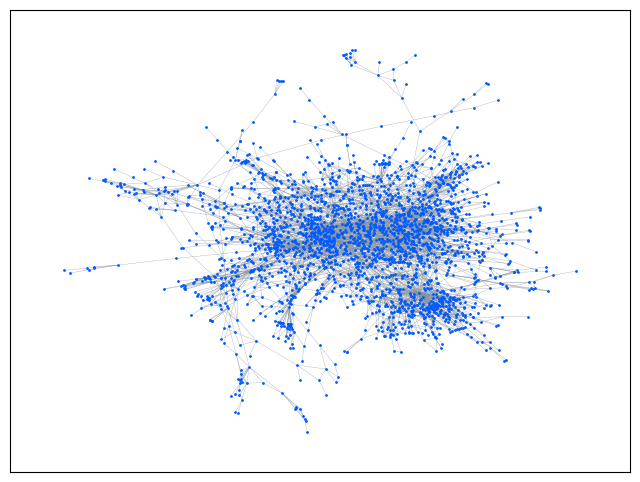

In [4]:
# spring_layout によってノードの座標（2次元配置）を計算
# 物理モデルに基づく力学的レイアウト（ばねモデル）を用いて、視覚的に見やすいグラフ構造を得る
pos = nx.spring_layout(G, seed=0)

# 描画用のFigureとAxesを作成（図のサイズは 8x6 インチ）
fig, ax = plt.subplots(figsize=(8, 6))

# グラフの描画
nx.draw_networkx(
    G,  # 対象のNetworkXグラフ
    ax=ax,  # 描画先のAxes
    pos=pos,  # 各ノードの座標を辞書で指定
    node_size=1,  # ノードの大きさ（小さめに設定）
    node_color="#005aff",  # ノードの色（青）
    labels={i: "" for i in range(n)},  # ラベル非表示（空文字を渡す）
    edge_color="#84919e",  # エッジの色（グレー寄りの青）
    width=0.2,  # エッジの太さ（細めに設定）
)

In [5]:
# 幅優先探索（BFS）で各ノードまでの距離を計算する
start = 0  # 探索の開始ノード（ノード番号 0）
dist = [-1 for i in range(n)]  # 各ノードへの距離（未到達を -1 とする）
dist[start] = 0  # 開始ノードの距離は 0
queue = [start]  # 探索用のキュー（FIFO）

# キューが空になるまで探索を続ける
while len(queue) > 0:
    x = queue.pop(0)  # キューの先頭からノードを取り出す
    for i in range(n):
        # 隣接していて、まだ訪れていないノードであれば
        if A[x, i] and dist[i] == -1:
            dist[i] = dist[x] + 1  # 距離を1足して記録
            queue.append(i)  # 次に探索すべきノードとしてキューに追加

findfont: Font family 'Segoe UI' not found.
findfont: Font family ['Segoe UI'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Segoe UI' not found.


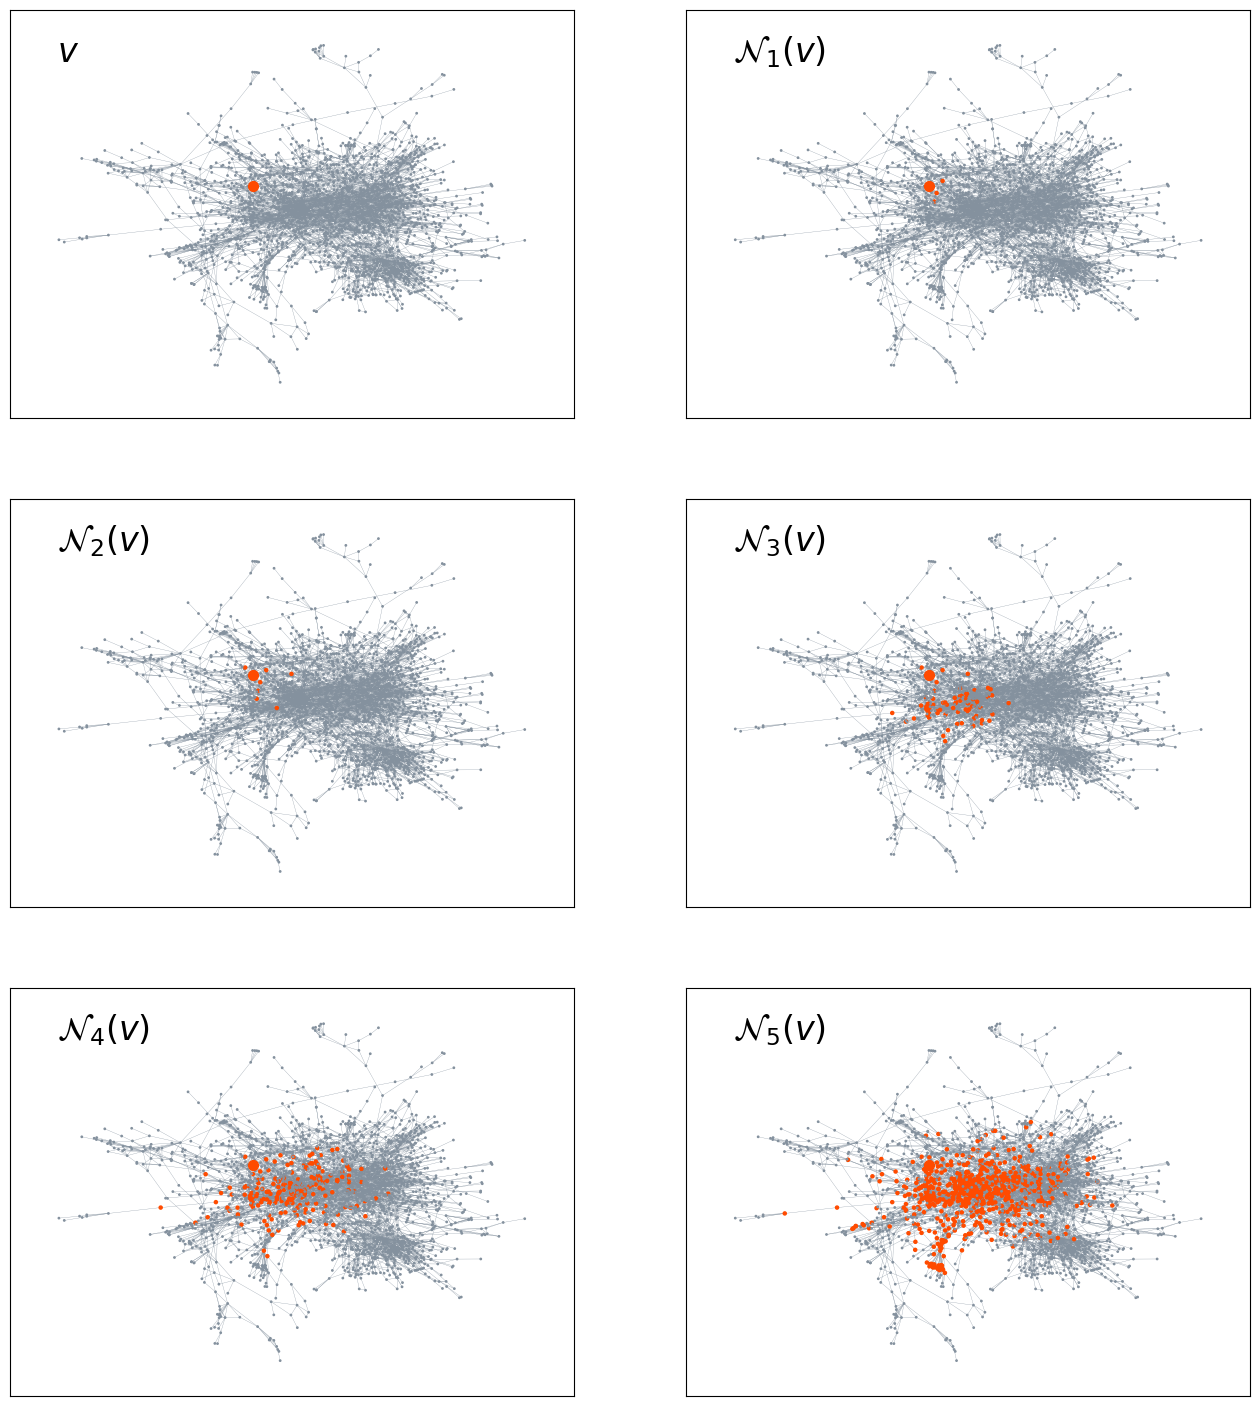

In [6]:
# 距離ごとのノード可視化（0〜5の範囲で順に描画）
fig = plt.figure(figsize=(16, 18))  # 図全体のサイズを指定

for d in range(6):  # d = 0〜5（距離の閾値）
    ax = fig.add_subplot(3, 2, 1 + d)  # サブプロットを6つ作成（3行2列のグリッド）

    # 全ノードの初期設定（非強調：灰色、小サイズ）
    node_color = ["#84919e" for i in range(n)]
    node_size = [1 for i in range(n)]

    # 距離がd以下のノードを強調表示（オレンジ、大サイズ）
    for i in range(n):
        if dist[i] <= d:
            node_color[i] = "#ff4b00"
            node_size[i] = 5

    # グラフ描画：posのレイアウトに基づいてノード・エッジを配置
    nx.draw_networkx(
        G,
        ax=ax,
        pos=pos,
        node_size=node_size,
        node_color=node_color,
        labels={i: "" for i in range(n)},  # ノードラベルは表示しない
        edge_color="#84919e",
        width=0.2,
    )

    # 開始ノードを目立たせてプロット（赤、サイズ大、最前面）
    ax.scatter(
        [pos[start][0]],
        [pos[start][1]],  # 座標
        s=50,
        c="#ff4b00",
        zorder=10,  # サイズ、色、描画順序
    )

    # 各サブプロットに注釈を追加（例：$\mathcal{N}_2(v)$）
    if d == 0:
        caption = "$v$"  # 開始ノードそのもの
    else:
        caption = "$\\mathcal{N}_" + str(d) + "(v)$"  # d-hop以内の近傍ノード

    # 注釈の位置とフォント設定
    ax.text(-0.9, 0.9, caption, fontfamily="Segoe UI", fontsize=24)  # 座標